In [120]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.stats
%matplotlib inline

In [121]:
#quantum trajectories decoherence 
#CASE 1 Ladder Operators
omega = 2
dt = 1e-2
N_w = 1
N_steps = int(1e3)

#define basis
base = np.array([[1,0],[0,1]])
coefficients = np.array([1 / np.sqrt(2), 1 / np.sqrt(2)])

#define jump operators + gammas
F = np.array([[[0,0],[1,0]],[[0,1],[0,0]]],dtype = "complex")
gamma = np.array([0,0.5])

In [104]:
#quantum trajectories decoherence 
#CASE 2 Random relative phase due to in intensity fluctuating photon noise
theta = 0.2 # random phase shift strength
omega = 1
dt = 1e-2
N_w = 1
N_steps = int(1e3)

#define basis
base = np.array([[1,0],[0,1]])
coefficients = np.array([1 / np.sqrt(2), 1 / np.sqrt(2)])

#define jump operators + gammas
F = np.array([[[1,0],[0,np.exp(1j * theta)]],[[1,0],[0,np.exp(-1j * theta)]]],dtype = "complex")
gamma = np.array([2,2])

In [105]:
#quantum trajectories decoherence 
#CASE 3 Phase flip due to quantum jumps
theta = np.pi # random phase shift strength
omega = 1
dt = 1e-2
N_w = 600
N_steps = int(1e3)

#define basis
base = np.array([[1,0],[0,1]])
coefficients = np.array([1 / np.sqrt(2), 1 / np.sqrt(2)])

#define jump operators + gammas
F = np.array([[[1,0],[0,-1]]],dtype = "complex")
gamma = np.array([0.5])

In [118]:
Sz =  np.array([[1,0],[0,-1]])
Sx =  np.array([[0,1],[1,0]])
#initiate walkers
psi0 = sum(coefficients[:,None] * base)
walkers = np.ones((N_w,2)) * psi0

S = gamma[:,None, None] * np.einsum('...ji,...jk->...ik',F.conj(),F, dtype="complex")

S_sum = np.sum(S,axis = 0)

H = omega * Sz + -1j * S_sum

U = scipy.linalg.expm(-1j * H * dt)
A = np.zeros(((np.size(F,axis=0)+1),np.size(F,axis = 1), np.size(F,axis = 2)),dtype="complex") #jump+unitary matrix set
A[0,:,:] = U
A[1:,:,:] = F

psi_avg = np.zeros((N_steps,np.size(psi0)),dtype = "complex")
x_spin = np.zeros((N_steps))
z_spin = np.zeros((N_steps))
S_rho = np.zeros((N_steps))
for i in range(0,N_steps):
    p_jump = np.einsum('hi,...ij,hj->h...' , walkers.conj(), S, walkers).real * dt
    p_sum = np.sum(p_jump,axis = 1)

    #for each jump take a random jump matrix
    p = np.zeros((N_w, np.size(F,axis=0)+1))
    p[:,1:]  = p_jump
    p[:,0] = 1 - p_sum #add extra column to p_jump with 1-p_sum
    
    x_k = np.arange(np.size(F,axis=0)+1)
    choice = np.zeros((N_w),dtype='int')
    for j in range(0, N_w):
        choice[j] = np.random.choice(x_k, 1 , p=p[j,:] )

    walkers = np.einsum('hij, hj -> hi',A[choice,:,:],walkers)
    walkers /= np.linalg.norm(walkers,axis = 1, keepdims = True)
    
    # Compute Von Neumann entropy
    rho = np.einsum('ki,kj',walkers,walkers.conj()) / N_w
    eigs = np.linalg.eigvalsh(rho)
    
    
    eigs[eigs<1e-99] = 0
    eigs = np.trim_zeros(np.sort(eigs))  # Trim zeros or very small numbers from eigenvalues to avoid computing 0*log(0)
    
    S_rho[i] = -eigs.dot(np.log2(eigs))
    
    x_spin[i] = np.einsum('hi,ij,hj', walkers.conj(), Sx, walkers).real / N_w
    z_spin[i] = np.einsum('hi,ij,hj', walkers.conj(), Sz, walkers).real / N_w

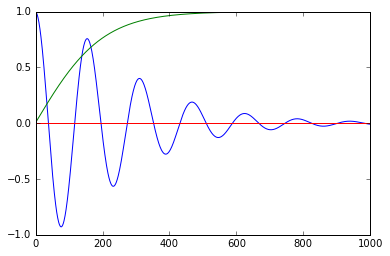

In [122]:
plt.plot(x_spin)
plt.plot(z_spin)
plt.plot(S_rho)